In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Load the cats_vs_dogs dataset
# The dataset is split into 80% training, 10% validation, and 10% testing.
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# Preprocess the data
IMG_SIZE = 160 # All images will be resized to 160x160

# Function is defined to preprocess the images and labels. The images are cast to float32, normalized to the range 
# [-1, 1], and resized. The labels are converted to binary (0 or 1).
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.where(label == 0, 0, 1)
    return image, label

In [4]:
# Apply the preprocessing function to the datasets
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Batch and shuffle the data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# The training data is shuffled and batched.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Create the base model from the pre-trained convnets
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:

base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [7]:

# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
# Build a model by chaining together the base model and the classification head
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
base_learning_rate = 0.0001
# The model is compiled with the Adam optimizer and SparseCategoricalCrossentropy loss function.
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_batches,
                    epochs=1,
                    validation_data=validation_batches)

# Evaluate the model
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

# Make predictions on the test set
predictions_test = model.predict(test_batches)

582/582 ━━━━━━━━━━━━━━━━━━━━ 346s 574ms/step - accuracy: 0.9686 - loss: 0.0761 - val_accuracy: 0.9850 - val_loss: 0.0911
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9852 - loss: 0.0584
Test accuracy : 0.9832330346107483
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step


In [8]:
loss, accuracy = model.evaluate(train_batches)
print('Train accuracy :', accuracy)

# Make predictions on the test set
predictions_train = model.predict(train_batches)

582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 117ms/step - accuracy: 0.9951 - loss: 0.0171
Train accuracy : 0.994626522064209
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step


Image 1: The model predicts this is a cat with a confidence of 37.610843658447266


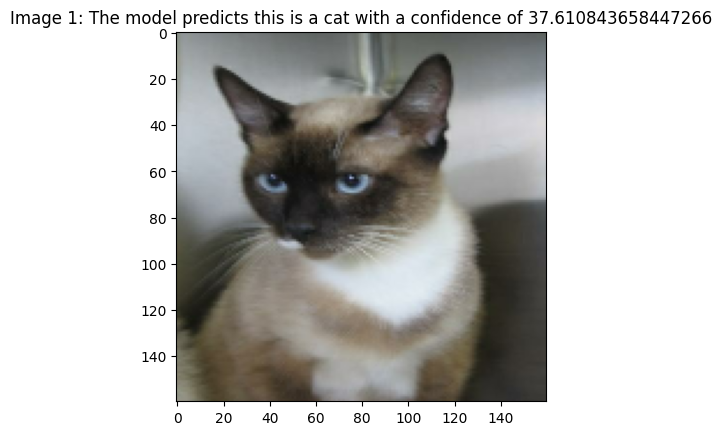

Image 2: The model predicts this is a dog with a confidence of 10.484911918640137


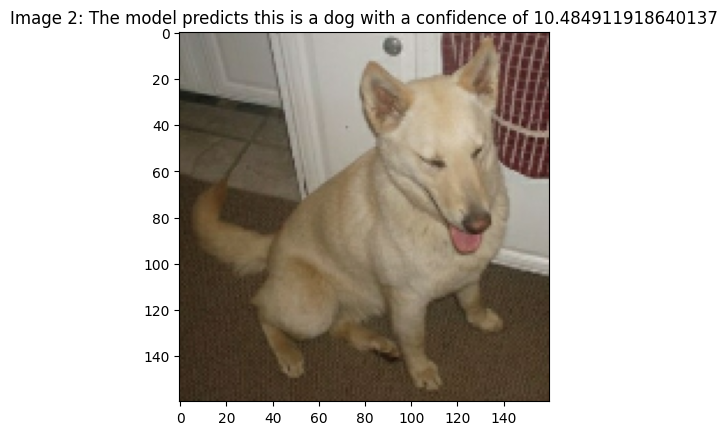

Image 3: The model predicts this is a dog with a confidence of 15.205755233764648


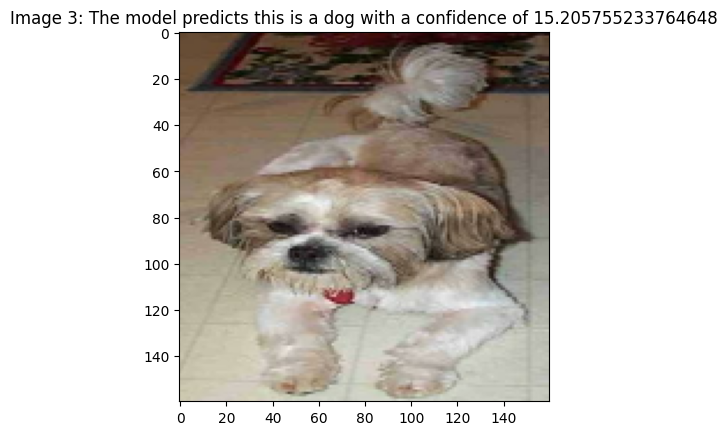

Image 4: The model predicts this is a cat with a confidence of 25.660701751708984


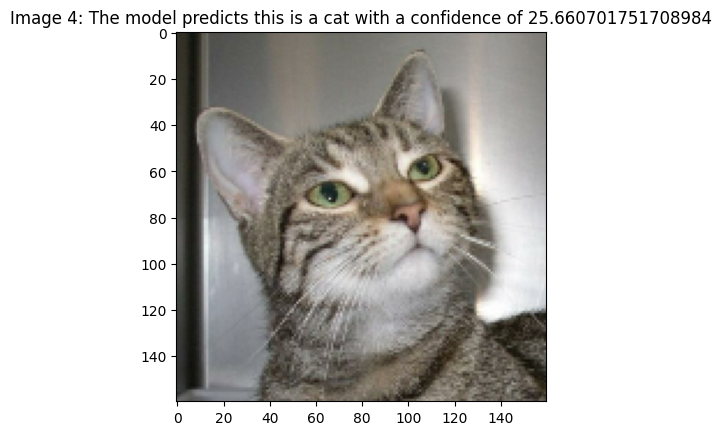

Image 5: The model predicts this is a cat with a confidence of 21.616012573242188


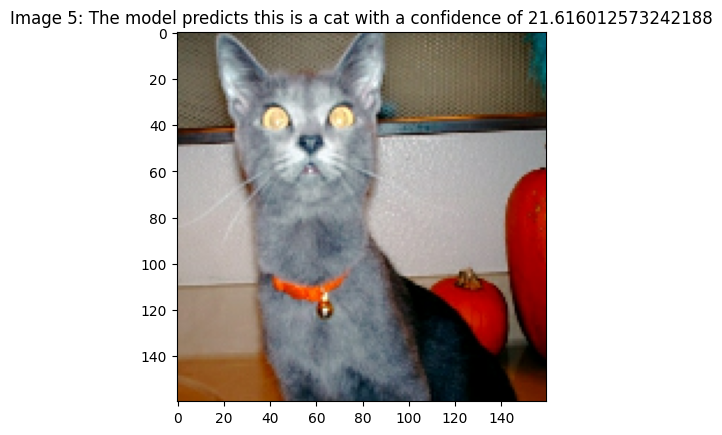

Image 6: The model predicts this is a cat with a confidence of 21.79995346069336


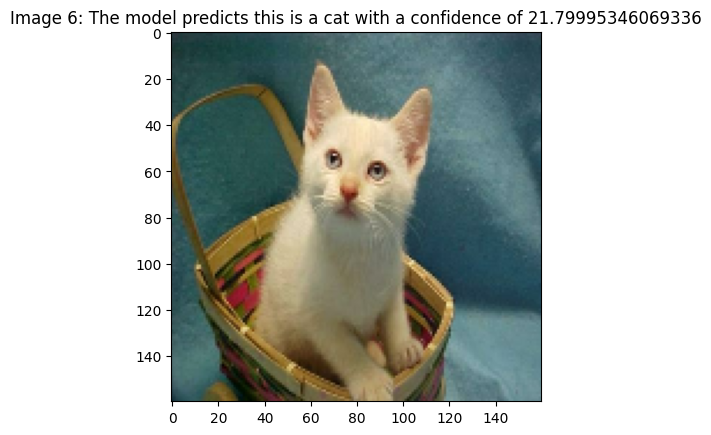

Image 7: The model predicts this is a dog with a confidence of 22.472152709960938


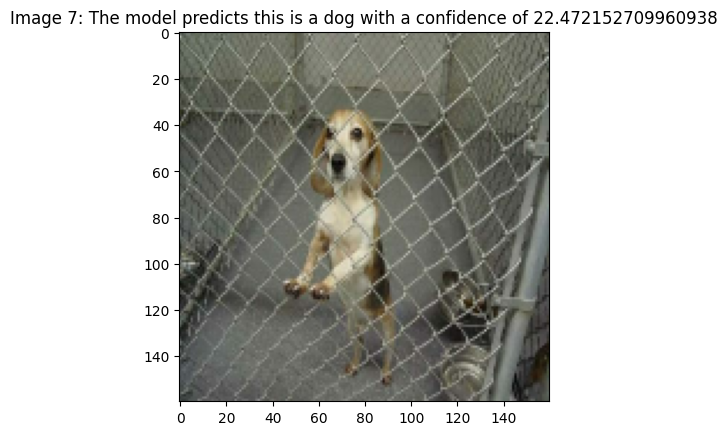

Image 8: The model predicts this is a cat with a confidence of 0.5767709016799927


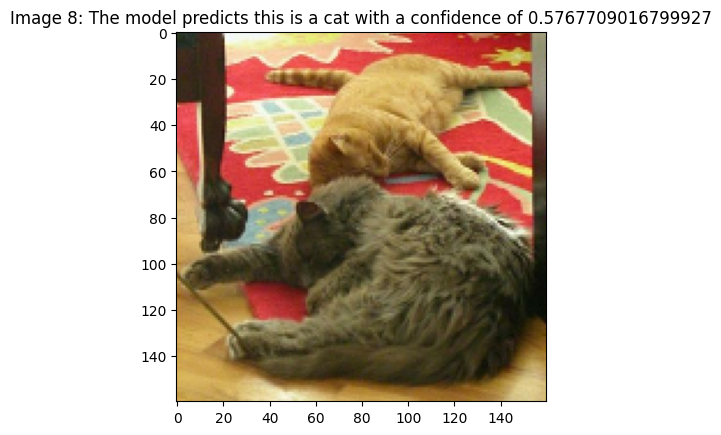

Image 9: The model predicts this is a cat with a confidence of 20.494243621826172


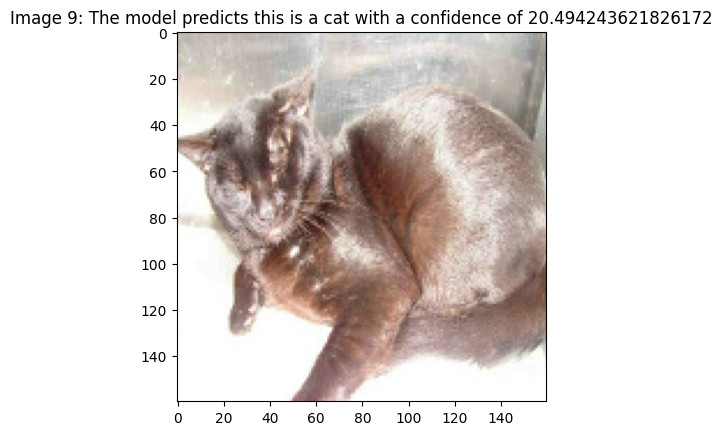

Image 10: The model predicts this is a cat with a confidence of 29.583791732788086


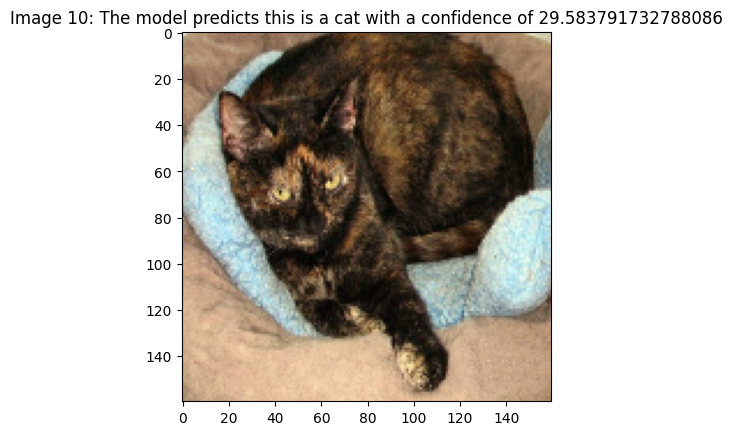

Image 11: The model predicts this is a dog with a confidence of 13.252769470214844


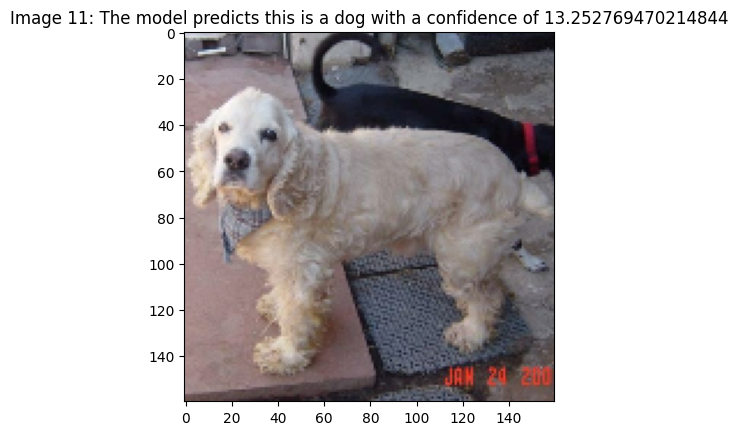

KeyboardInterrupt: 

In [9]:
# Iterate over the test set
for i, (img, label) in enumerate(test_batches.unbatch().take(len(predictions_test))):
    # Make a prediction
    prediction = predictions_test[i]

    # Print a description for the prediction
    if prediction > 0:
        description = f"Image {i+1}: The model predicts this is a dog with a confidence of {np.squeeze(prediction)}"
    else:
        description = f"Image {i+1}: The model predicts this is a cat with a confidence of {np.squeeze(-prediction)}"

    print(description)

    # Display the image
    plt.figure()
    plt.imshow((img+1)/2)  # Scale the image pixels back to [0, 1]
    plt.title(description)  # Add a title to the image plot
    plt.show()

    # Add a delay
    time.sleep(5)  # Sleep for 1 second
